#### Credit: 
Kim Gerdes, Kirian Guiller

In [1]:
## constants, for later
WINDOW_SIZE = 3
VOCAB_SIZE = 5000
MEMORY_LIMIT = 10000
EMBED_DIM = 100

# A dive into embeddings

## Outline:

### Part 1. Data extraction, cleaning, tokenization, building a train set (skip gram)

### Part 2. Learning word2vec witjh pytorch

### Part 3. Studying the result (learned embedding) (separate file, see TP6.3)

-----------

### Part 1. Data extraction, cleaning, tokenization, building a train set (skip gram)


Preliminary steps:
- tokenization (very simple example)
- token-words vs token-indices 
- initialization
- visualization
- forward, cost function, backward, training
- first on a single sentence, then on a bigger text

Main goal: understand the successive transformations which allow to get a decent vectorial representation of words.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os, time
## handy files-loading-management: glob
from glob import glob
# re as Regular Expression
import re
import json

## Counter: counting occurences easily (lazy method)
from collections import Counter

In [3]:
import torch
import torch.nn as nn



# Part 1. Data extraction, cleaning, tokenization, building a train set (skip gram)

We perform the following steps, first on a short sentence:
- 1.1 tokenization
- 1.2 converting to indices (almost a one-hot vector)
- 1.3 generate training data (skip gram style)
- 1.4 Same operations but for an actual corpus


## 1.1 Tokenization 
We convert a single sentence into tokens, i.e. words or equivalent, essentially

In [4]:
## simple tokenization:
phrase = "Il m’a bien ennervée, ce gars-là, avec ce copier-coller !"
retoken = re.compile(r"\w+")
retoken.findall(phrase.lower().replace('’',"'"))

['il',
 'm',
 'a',
 'bien',
 'ennervée',
 'ce',
 'gars',
 'là',
 'avec',
 'ce',
 'copier',
 'coller']

In [5]:
## more advanced tokenization...
phrase = "Il m'a bien ennervée, ce gars-là, avec ce copier-coller !"
retoken = re.compile(r"\w+'?")
# the simpler is to first replace:
reclitic = re.compile(r"-(là|ci|je|tu|il|elle|t-il|t-elle|ils|elles|t-ils|t-elles|nous|vous)")
phrase = reclitic.sub(r' \1',phrase)
retoken = re.compile(r"[\w-]+'?")
retoken.findall(phrase.lower())

['il',
 "m'",
 'a',
 'bien',
 'ennervée',
 'ce',
 'gars',
 'là',
 'avec',
 'ce',
 'copier-coller']

In [6]:
def tokenize(phrase):
    retoken = re.compile(r"\w+'?")
    retoken = re.compile(r"[\w-]+'?")
    return retoken.findall(reclitic.sub(r' \1',phrase.lower()).replace('’',"'").replace('',"'")) 
    # problèmes d'encodage de certains fichiers : dEDF

In [7]:
tokens = tokenize(phrase)
tokens

['il',
 "m'",
 'a',
 'bien',
 'ennervée',
 'ce',
 'gars',
 'là',
 'avec',
 'ce',
 'copier-coller']

## 1.2 Converting to indices (almost a one-hot vector)

(and storing the mapping of course)

In [8]:
def mapping(tokens):
    """
    tokens : list of tokens
    tok2id : dictionnary : link between tokens (in letters) and token-index (ordered by frequence)
    id2tok : dictionnary:  inverse of tok2id
    fin todo
    """
    tok2id = dict()
    id2tok = dict()

    for i, (token, _) in enumerate(Counter(tokens).most_common()):
        tok2id[token] = i
        id2tok[i] = token

    return tok2id, id2tok

In [9]:
tok2id, id2tok = mapping(tokens)
tok2id, id2tok

({'ce': 0,
  'il': 1,
  "m'": 2,
  'a': 3,
  'bien': 4,
  'ennervée': 5,
  'gars': 6,
  'là': 7,
  'avec': 8,
  'copier-coller': 9},
 {0: 'ce',
  1: 'il',
  2: "m'",
  3: 'a',
  4: 'bien',
  5: 'ennervée',
  6: 'gars',
  7: 'là',
  8: 'avec',
  9: 'copier-coller'})

## 1.3 Create training data (skip-gram style)

In [10]:
def generate_training_data(tokens, tok2id, window_size):
    """
    we create pairs of X,Y for training:
    X and Y have same length: (index of central word, index of one of the words observed around the central one)
    """
    vocabulary = tok2id.keys()
    X = []
    Y = []
    N = len(tokens)
    if N >= 2*window_size+1:
        ## replace unknown words with <unk>
        for i, tok in enumerate(tokens):
            if tok not in vocabulary:
                tokens[i] = "<unk>"

        ## fill in X and Y:
        for i in range(window_size,N-window_size-1):
            context_tokens_list = []
            X.append(tok2id[tokens[i]]) ## input
            ys = np.zeros(VOCAB_SIZE+1)
            for j in range(i-window_size, i+window_size+1):
                if i!=j: #  and 0<=j<N:
                    ys[tok2id[tokens[j]]] += 1
            Y.append(ys)  ## context (to be predicted)
            
    return X, Y

In [11]:
tokens

['il',
 "m'",
 'a',
 'bien',
 'ennervée',
 'ce',
 'gars',
 'là',
 'avec',
 'ce',
 'copier-coller']

In [12]:
window_size = 3
X, Y = generate_training_data(tokens, tok2id, window_size)
X, Y

([4, 5, 0, 6],
 [array([1., 1., 1., ..., 0., 0., 0.]),
  array([1., 0., 1., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([2., 0., 0., ..., 0., 0., 0.])])

In [13]:
phrase

"Il m'a bien ennervée, ce gars là, avec ce copier-coller !"

In [14]:
id2tok[4], id2tok[5], id2tok[0], id2tok[6]

('bien', 'ennervée', 'ce', 'gars')

In [15]:
id2tok[0], id2tok[1], id2tok[2], id2tok[3], id2tok[5], id2tok[6]

('ce', 'il', "m'", 'a', 'ennervée', 'gars')

In [16]:
Y[0][:15]

array([1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

## 1.4 Same operations but now for an actual corpus

- First, we need to look at word frequencies, and decide a cut-off: words (types) more frequent than this cutoff will be part of the vocabulary, less frequent types will be replaced with the tyoe "<unk>" (unknown)
- Then, we open again all files and encode their sentences into one-hot vectors.

###  (1)  Data Loading, tokenization, counting types frequencies

### WARNING : of course, unzip "Plain text" and put it in the right place...

In [17]:
textfiles = [y for x in os.walk('/home/flandes/data/Plain text') for y in glob(os.path.join(x[0], '*.txt'))]
print('We have ',len(textfiles),' text files.')

We have  1723  text files.


In [18]:
def tokenize(phrase):
#     retoken = re.compile(r"\w+'?")
    retoken = re.compile(r"[\w-]+'?")
    reclitic = re.compile(r"-(là|ci|je|tu|il|elle|t-il|t-elle|ils|elles|t-ils|t-elles|nous|vous)")
    return retoken.findall(reclitic.sub(r' \1',phrase.lower()).replace('’',"'").replace('',"'")) 
    # problèmes d'encodage de certains fichiers : dEDF

In [19]:
# this Counter helps us count types occurences in a few lines:
wordcounter = Counter()
for f in textfiles:
    tokenized_text = tokenize(open(f, encoding='iso-8859-15').read())
    wordcounter.update(Counter(tokenized_text))

In [20]:
wordcounter["equipe"], wordcounter

(12,
 Counter({'la': 32412,
          'polémique': 69,
          'aimé': 31,
          'jacquet-': 1,
          "l'": 24486,
          'equipe': 12,
          'au': 7038,
          'tribunal': 99,
          'g': 18,
          'da': 12,
          'il': 8683,
          "n'": 4381,
          'a': 10881,
          'pas': 6331,
          'habitude': 56,
          'des': 17318,
          'salles': 63,
          "d'": 17285,
          'audience': 31,
          'jacquet': 11,
          'le': 25571,
          'directeur': 269,
          'technique': 118,
          'national': 329,
          'du': 12887,
          'football': 210,
          'français': 1040,
          'préfère': 41,
          'les': 21847,
          'causeries': 1,
          'avant-match': 3,
          'aux': 3020,
          'plaidoiries': 1,
          'vendredi': 289,
          '25': 248,
          'avril': 286,
          'était': 1417,
          'pourtant': 366,
          'poursuivi': 34,
          '-': 2334,
          'ainsi'

In [21]:
print('Nous avons',len(wordcounter),'types et', sum(wordcounter.values()),'tokens.')
print('Voici les 10 mots les plus courants :', wordcounter.most_common(10))

Nous avons 53683 types et 1067469 tokens.
Voici les 10 mots les plus courants : [('de', 56067), ('la', 32412), ('le', 25571), ("l'", 24486), ('les', 21847), ('à', 21164), ('et', 19041), ('des', 17318), ("d'", 17285), ('en', 15374)]


### (2) Ordering types by their frequency, definition of the vocabulary

In [22]:
# VOCAB_SIZE = 5000

## NOTE !!! IT IS VERY IMPORTANT TO ORDER THEM BY FEQUENCY, HERE !!! 
common_words_list_of_pairs = wordcounter.most_common(VOCAB_SIZE)  # sorts types by their frequency of occurence
common_words_list_of_pairs[:7]

[('de', 56067),
 ('la', 32412),
 ('le', 25571),
 ("l'", 24486),
 ('les', 21847),
 ('à', 21164),
 ('et', 19041)]

<AxesSubplot: >

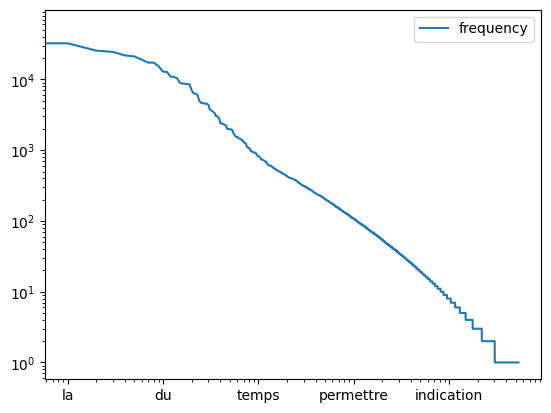

In [23]:
freq_df = pd.DataFrame.from_dict(wordcounter, orient='index', columns=['frequency']).sort_values(by='frequency', ascending=False)
freq_df.plot(loglog=True)

### (3) Converting to indices (almost a one-hot vector)

In [24]:
## create a dictionnary from token to id (arbitrary ID)
## and one from ID to token (useful for inference on other texts too !)
tok2id = {}
id2tok = {}
other_words_token = "<unk>"  # special token to describe all other words (not in the vocab)

i=0
token = other_words_token
tok2id[token] = i
id2tok[i] = token
i+=1
for element in common_words_list_of_pairs:  ## it's crucial that we ordered types by frequency !!
    token, freq = element
    tok2id[token] = i
    id2tok[i] = token
    i+=1

In [25]:
common_words_list_of_pairs[-1]

('exploits', 19)

In [26]:
wordcounter[common_words_list_of_pairs[-1][0]]

19

In [27]:
# tok2id

In [28]:
# id2tok

In [29]:
## we save our dicts for later use
myjson = json.dumps(tok2id)
f = open("tok2id.json","w")
f.write(myjson)
f.close()
myjson = json.dumps(id2tok)
f = open("id2tok.json","w")
f.write(myjson)
f.close()

In [30]:
vocabulary = tok2id.keys()
# vocabulary

### [optionnal] Quick study of the relationship between type length and frequency of that type:

In [31]:
print('longueur moyenne dans le dictionnaire (sur les types) :',sum([len(t) for t in wordcounter])/len(wordcounter))
print('longueur moyenne dans le texte (sur les tokens) :',sum([len(t)*f for t,f in wordcounter.items()])/ sum(wordcounter.values()))
print('les mots les plus longs :', sorted(wordcounter, key=lambda x:len(x), reverse=True)[:10])

longueur moyenne dans le dictionnaire (sur les types) : 8.142931654341226
longueur moyenne dans le texte (sur les tokens) : 4.81165354684773
les mots les plus longs : ['pianiste-musicien-concepteur-décorateur-éclairagiste-', 'franco-belgo-hollando-italo-espagnol', 'cyber-philosophico-futuriste', 'contractuels-fonctionnaires', 'restructuration-liquidation', 'politico-constitutionnelle', 'gynécologues-obstétriciens', 'énergie-rail-communication', 'saint-gilles-croix-de-vie', 'argentino-ritalo-parigote']


In [32]:
lenfreq = {} # contiendra longueur du mot vers la fréquence dans le dictionnaire
for t,f in wordcounter.items():
    lenfreq[len(t)] = lenfreq.get(len(t),0)+1 # si remplace +1 par +f, on a la relation longueur / fréquence dans les textes
print(lenfreq)

{2: 418, 9: 6707, 4: 2719, 8: 7668, 6: 6495, 1: 43, 3: 1855, 7: 7739, 11: 3664, 5: 4571, 13: 1567, 12: 2471, 10: 5248, 18: 136, 17: 201, 24: 10, 14: 1010, 15: 601, 20: 48, 16: 333, 22: 27, 19: 91, 21: 26, 23: 18, 25: 9, 36: 1, 26: 3, 53: 1, 28: 1, 27: 2}


In [33]:
freq_df = pd.DataFrame.from_dict(lenfreq, orient='index', columns=['frequency']).sort_values(by='frequency', ascending=False)
freq_df.head()

frequency
7        7739
8        7668
9        6707
6        6495
10       5248

<AxesSubplot: title={'center': 'notons la long tail!'}>

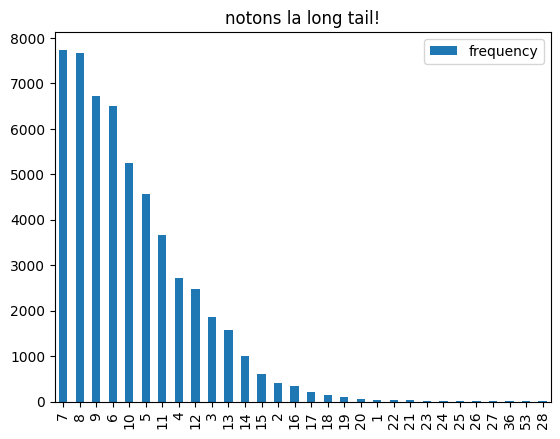

In [34]:
freq_df.plot(kind='bar', title='notons la long tail!')

### (4) Create training data (skip-gram style)

In [35]:
# we limit Y to be MEMORY_LIMIT x VOCAB_SIZE at most, otherwise we may lack memory
# MEMORY_LIMIT = 20000

### ROOM FOR IMPROVEMENT:

**(maybe next year I'll do it, don't try it now, I'd say)**

better than this generation of Y as a hard-coded numpy array (torch tensor), use this function at batch loading time: i.e., at every iteration of processing a batch, load some text files and convert them in that way.. 

Concretly, we should write a proper DataLoader (torch object) that does this. 

It's not a problem if all batches do not have exactly the same size

## But today we do it dirty-style (hard-coded, all-in-memory-style)

So, choose the variable `MEMORY_LIMIT` carefully, depending on how much RAM you have.

In [36]:
# WINDOW_SIZE =3
window_size=WINDOW_SIZE
X = []
Y = []
filenumber = -1
for f in textfiles:
    filenumber+=1
    with open(f, encoding='iso-8859-15') as f:
        texte = f.read()
        phrases = texte.split(".")
        for phrase in phrases:
            tokens = tokenize(phrase)
            N = len(tokens)
            if N >= 2*window_size+1:
                ## replace unknown words with <unk>
                for i, tok in enumerate(tokens):
                    if tok not in vocabulary:
                        tokens[i] = "<unk>"

                ## fill in X and Y:
                for i in range(window_size,N-window_size-1):
                    X.append(tok2id[tokens[i]]) ## input
                    ys = np.zeros(VOCAB_SIZE+1)
                    for j in range(i-window_size, i+window_size+1):
                        if i!=j: #  and 0<=j<N:
                            ys[tok2id[tokens[j]]] += 1
                    Y.append(ys)  ## context (to be predicted)
    if len(Y) > MEMORY_LIMIT:
        print(filenumber)
        break
       

18


In [37]:
X = np.array(X)
X = torch.tensor(X)
Y = torch.tensor(np.array(Y)) 

In [38]:
X.dtype

torch.int64

In [39]:
X.shape, Y.shape

(torch.Size([10243]), torch.Size([10243, 5001]))

In [40]:
len(tok2id.keys())

5001


### Part 2. Learning word2vec witjh pytorch


### About the difference between nn.Embedding vs nn.Linear: 

https://stackoverflow.com/questions/65445174/what-is-the-difference-between-an-embedding-layer-with-a-bias-immediately-afterw

In this model, you should use:
- a layer with `nn.Embedding`
- a layer with nn.Linear (bias is useless)
- no activation function is needed
- even the softmax is implicit, it's hidden in the Loss (BCELoss)

In [41]:
import torch.nn as nn
class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size, bias=False)

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        logits = self.linear(x)
        ## no softmax because it is hiddent in the BCE loss (nn.CrossEntrolpyLoss method)
        return logits

In [42]:
def train(num_epochs, batch_size, criterion, optimizer, model, trainset):
    # we re-define `trainloader` so as to be able to choose the batch size:
#     trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
    X, Y = trainset
    N = X.shape[0]
    N -= X.shape[0]%batch_size
    batch_number = X.shape[0]//batch_size    
    
    t0 =time.time()
    
    model.train() ## tells pytorch we are in train mode, not in test mode.
    running_losses=[]
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        
#         for i, data in enumerate(trainloader, 0):            
#             # get the inputs; data is a list of [inputs, labels]
#             X_batch, Y_batch = data
        running_loss = 0.0
    
        ## here we do batches by hand !
        batch_inds = list(range(0, N-batch_size, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[i:i+batch_size]
            Y_batch = Y[i:i+batch_size, :]

            # zero the parameter's gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize :            
            ## forward pass
            ybatch = model(X_batch)  # because torch tensors keep parameters values AND the computational graph,
                                     # the torch object 'output' will be able to store also the gradients
            # note: outputs has a shape:  batch_size x #labels  = 4 x 10  (+gradients)

            ## backward pass
            loss = criterion(ybatch, Y_batch)  ## loss is also a torch object, so it also has the comput. graph.
            loss.backward() # computes and stores the gradients next to the tensors of parameters themselves.
            # at this point, the object 'model' has the gradients in it at the correct value.

            ## update of gradients
            optimizer.step() # updates the parameters wrt the local gradient
            ## recall that we defined:  optimizer = optim.SGD(model.parameters(), ... so it knows about the parameters.

            
            # print statistics
            running_loss += loss.item()
        print(f'[{epoch + 1}] loss: {running_loss}')
        running_losses.append(running_loss)
        running_loss = 0.0
        
    t1 =time.time()
    print('Finished Training. It took '+str(t1-t0)+" seconds")
    return running_losses


## To understand how things work: quick debug out of the loop !

You can check for instance that your loss computes whay you want, here

In [43]:
# vocab_size = VOCAB_SIZE+1
# embed_dim = 100
# myOwnWord2Vec_model = SkipGram_Model(vocab_size=vocab_size, embed_dim=embed_dim) ## only 1 layer !!

# learning_rate=3e-4
# num_epochs=10
# batch_size=128
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(myOwnWord2Vec_model.parameters(), lr=learning_rate)
# trainset = (X, Y)

In [44]:
# ## we try 1 epoch, just to check things are ok:
# model = myOwnWord2Vec_model

# optimizer.zero_grad()
# y = model(X)

# ## backward pass
# loss = criterion(y, Y)  ## loss is also a torch object, so it also has the comput. graph.
# loss.backward() # computes and stores the gradients next to the tensors of parameters themselves.
# # at this point, the object 'model' has the gradients in it at the correct value.

# ## update of gradients
# optimizer.step() # updates the parameters wrt the local gradient
# ## recall that we defined:  optimizer = optim.SGD(model.parameters(), ... so it knows about the parameters.

In [45]:
# loss

In [46]:
# ## we can compute the loss "by hand" to check it's what we expect 
# ## with all the pytorch things happening inside BCELoss, we can't be too sure...
# softmax = nn.Softmax(dim=1)
# softy = np.array(softmax(y.detach()))
# softy.shape, softy.sum(1), softy.sum(1).shape

In [47]:
# ## it does match :D
# np.sum(np.array(Y)*np.log(softy))/X.shape[0]

In [48]:
# N  = X.shape[0]
# batch_number = X.shape[0]//batch_size
# X.shape[0]%batch_size


In [49]:
## With SGD, it's pretty slow:

vocab_size = VOCAB_SIZE+1
embed_dim = EMBED_DIM
myOwnWord2Vec_model = SkipGram_Model(vocab_size=vocab_size, embed_dim=embed_dim) ## only 1 layer !!
trainset = (X, Y)

learning_rate=1e-2
num_epochs=10
batch_size=128

criterion = nn.CrossEntropyLoss()  ## and note BCELoss
optimizer = torch.optim.SGD(myOwnWord2Vec_model.parameters(), lr=learning_rate)

In [50]:
running_losses = train(num_epochs, batch_size, criterion, optimizer, myOwnWord2Vec_model, trainset)

[1] loss: 4036.244939021766
[2] loss: 3922.5141561562195
[3] loss: 3848.3220722563565
[4] loss: 3794.528399943374
[5] loss: 3752.1130423219875
[6] loss: 3717.6470357915387
[7] loss: 3689.0134061053395
[8] loss: 3664.69722489547
[9] loss: 3643.116023585899
[10] loss: 3623.561365770409
Finished Training. It took 12.214052438735962 seconds


## TODOs:
- make a DataLoader to use the whole corpus even on a small machine
- learn with proper scheduler and for long enough ;)
- save the model
- load the model

In [51]:
## With Adam, it's better:

vocab_size = VOCAB_SIZE+1
embed_dim = EMBED_DIM
myOwnWord2Vec_model = SkipGram_Model(vocab_size=vocab_size, embed_dim=embed_dim) ## only 1 layer !!

trainset = (X, Y)

In [52]:
learning_rate=1e-2
num_epochs=100
batch_size=128

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(myOwnWord2Vec_model.parameters(), lr=learning_rate)

running_losses = train(num_epochs, batch_size, criterion, optimizer, myOwnWord2Vec_model, trainset)

[1] loss: 3420.448083839612
[2] loss: 2706.5513483630493
[3] loss: 2475.8068712194217
[4] loss: 2378.7229852567543
[5] loss: 2333.7530968075152
[6] loss: 2303.591765975114
[7] loss: 2284.1825587759777
[8] loss: 2262.8762841735734
[9] loss: 2238.9586348207667
[10] loss: 2221.4314747551252
[11] loss: 2211.7355947014003
[12] loss: 2191.6400867187767
[13] loss: 2176.313253259752
[14] loss: 2164.1390225987125
[15] loss: 2154.7834730090835
[16] loss: 2144.5773177301016
[17] loss: 2141.1733308612893
[18] loss: 2132.3828069570154
[19] loss: 2126.588099247907
[20] loss: 2121.240489011223
[21] loss: 2112.9396114997217
[22] loss: 2114.0895169390424
[23] loss: 2111.168355880829
[24] loss: 2111.481973316055
[25] loss: 2108.273145237763
[26] loss: 2101.2541626228776
[27] loss: 2103.1036734898444
[28] loss: 2094.2907802323607
[29] loss: 2094.7619151997496
[30] loss: 2095.6235583699017
[31] loss: 2095.210019539765
[32] loss: 2088.6327545025415
[33] loss: 2094.566253106781
[34] loss: 2085.668212810997


In [53]:
# learning_rate=1e-1
# num_epochs=1000
# batch_size=128

# running_losses = train(num_epochs, batch_size, criterion, optimizer, myOwnWord2Vec_model, trainset)

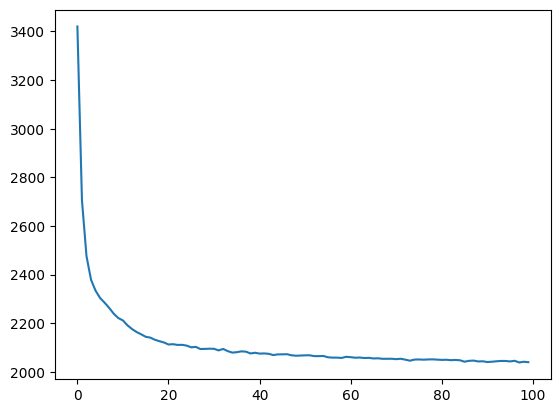

In [54]:
plt.plot(running_losses)

In [55]:
# learning_rate=1e-2
# num_epochs=10
# batch_size=128

# running_losses = train(num_epochs, batch_size, criterion, optimizer, myOwnWord2Vec_model, trainset)

In [56]:
torch.save(myOwnWord2Vec_model.state_dict, "myOwnWord2Vec_model.torch.model_V="+str(vocab_size)+"_d="+str(embed_dim))
# vocab_size = VOCAB_SIZE+1
# embed_dim = 100

In [38]:
'reine' in tok2id.keys()

False

In [57]:
'roi' in tok2id.keys()

True

In [58]:
len(tok2id.keys())

5001

In [59]:
def token_to_vect(token):
    vector = myOwnWord2Vec_model.embeddings(torch.tensor([tok2id[token]]))
    vector_norm = np.linalg.norm(vector.detach())
    return vector/vector_norm

In [60]:
all_words = torch.tensor(np.arange((VOCAB_SIZE+1), dtype=int))
all_vectors = np.array(myOwnWord2Vec_model.embeddings(all_words) .detach())
normes = np.linalg.norm(all_vectors, axis=1).reshape(-1,1)
all_vectors = all_vectors / normes


In [61]:
vecteur_cible = token_to_vect("roi")+token_to_vect("femme")-token_to_vect("homme")
vecteur_cible = np.array(vecteur_cible.detach())
dot_prod = (all_vectors @ vecteur_cible.T)# / np.linalg.norm(vector.detach())
inds = dot_prod[:,0].argsort()
[id2tok[ind] for ind in np.array(inds)[::-1][:10]]

['femme',
 'roi',
 'attention',
 'accepter',
 'saut',
 'vise',
 'voici',
 'formule',
 'nicole',
 'pêche']

In [68]:
vecteur_cible = token_to_vect("médecin")+token_to_vect("femme")-token_to_vect("homme")
vecteur_cible = np.array(vecteur_cible.detach())
dot_prod = (all_vectors @ vecteur_cible.T)# / np.linalg.norm(vector.detach())
inds = dot_prod[:,0].argsort()
[id2tok[ind] for ind in np.array(inds)[::-1][:10]]

['médecin',
 'femme',
 'semaines',
 'cinquième',
 'plusieurs',
 'banquiers',
 'sursis',
 'annoncent',
 'aériennes',
 'soirées']

# Conclusion: of course, not amazing.

## Why ?
- the corpus is way too small
- we train for too few epochs, because we are slow. Why are we slow ?
    - we run on CPU
    - probably the hyper-params are not well chosen
    - we are slow because we do not do the trick of sampling at random the negative samples: our backward step takes way too much time
- the vocabulary is too small

----------------

## TODOs: (for later, not today !)
- make a DataLoader to use the whole corpus even on a small machine
- learn with proper scheduler and for long enough ;)
- save the model
- load the model